# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [24]:
EGO_USER = 0 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f,encoding='latin1')
g = nx.Graph(adj)

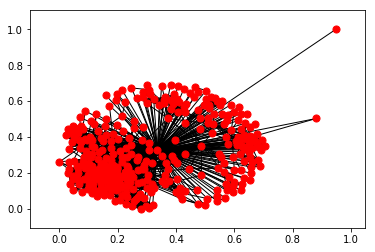

In [3]:
# draw network
g = nx.Graph(adj)
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Data Preprocessing

In [26]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
#tf.set_random_seed(0)
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [27]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [28]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [29]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

np.random.seed(0) # IMPORTANT: guarantees consistent train/test splits
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

 40%|████      | 1160/2866 [00:09<00:13, 125.27it/s]


In [30]:
train_edges

array([[ 14, 312],
       [113, 291],
       [ 38, 117],
       ...,
       [196, 204],
       [108, 320],
       [ 25, 322]], dtype=int32)

In [73]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", int(adj.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 348
Total edges: 2866
Training edges (positive): 1721
Training edges (negative): 1721
Validation edges (positive): 286
Validation edges (negative): 286
Test edges (positive): 859
Test edges (negative): 859


## 3. Initialize VAE Model

In [74]:
# Define hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 300
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [75]:
# Define placeholders


#tf.disable_v2_behavior()
placeholders = {
    'features': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj_orig': tf.compat.v1.sparse_placeholder(tf.float32),
    'dropout': tf.compat.v1.placeholder_with_default(0., shape=())
}

In [76]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [79]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

AttributeError: module 'tensorflow' has no attribute 'variable_scope'

In [13]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        neg.append(adj_orig[e[0], e[1]]) # actual value (0)

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [14]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.94340 train_acc= 0.45906 val_roc= 0.79712 val_ap= 0.80699 time= 0.15010
Epoch: 0002 train_loss= 1.71087 train_acc= 0.46866 val_roc= 0.79640 val_ap= 0.80296 time= 0.05808
Epoch: 0003 train_loss= 1.47331 train_acc= 0.47842 val_roc= 0.79747 val_ap= 0.80064 time= 0.04247
Epoch: 0004 train_loss= 1.42446 train_acc= 0.46915 val_roc= 0.80191 val_ap= 0.80072 time= 0.04176
Epoch: 0005 train_loss= 1.35798 train_acc= 0.48294 val_roc= 0.80879 val_ap= 0.80580 time= 0.04005
Epoch: 0006 train_loss= 1.32575 train_acc= 0.48358 val_roc= 0.81789 val_ap= 0.81215 time= 0.04869
Epoch: 0007 train_loss= 1.31170 train_acc= 0.48803 val_roc= 0.82824 val_ap= 0.82300 time= 0.05095
Epoch: 0008 train_loss= 1.28302 train_acc= 0.48722 val_roc= 0.83459 val_ap= 0.83004 time= 0.04021
Epoch: 0009 train_loss= 1.25093 train_acc= 0.49032 val_roc= 0.83532 val_ap= 0.83447 time= 0.03957
Epoch: 0010 train_loss= 1.18308 train_acc= 0.49427 val_roc= 0.83444 val_ap= 0.83650 time= 0.04250
Epoch: 0011 train_lo

Epoch: 0086 train_loss= 0.54929 train_acc= 0.52007 val_roc= 0.84511 val_ap= 0.83809 time= 0.05852
Epoch: 0087 train_loss= 0.54760 train_acc= 0.52542 val_roc= 0.84475 val_ap= 0.83891 time= 0.06657
Epoch: 0088 train_loss= 0.55055 train_acc= 0.50755 val_roc= 0.84498 val_ap= 0.83952 time= 0.05376
Epoch: 0089 train_loss= 0.55087 train_acc= 0.51420 val_roc= 0.84394 val_ap= 0.83923 time= 0.03840
Epoch: 0090 train_loss= 0.54866 train_acc= 0.50973 val_roc= 0.84401 val_ap= 0.83992 time= 0.04128
Epoch: 0091 train_loss= 0.54472 train_acc= 0.52094 val_roc= 0.84471 val_ap= 0.84037 time= 0.04787
Epoch: 0092 train_loss= 0.54835 train_acc= 0.51257 val_roc= 0.84621 val_ap= 0.84059 time= 0.03922
Epoch: 0093 train_loss= 0.54455 train_acc= 0.51524 val_roc= 0.84881 val_ap= 0.84155 time= 0.03947
Epoch: 0094 train_loss= 0.54491 train_acc= 0.51972 val_roc= 0.85064 val_ap= 0.84276 time= 0.04106
Epoch: 0095 train_loss= 0.54529 train_acc= 0.52370 val_roc= 0.85071 val_ap= 0.84304 time= 0.04445
Epoch: 0096 train_lo

Epoch: 0170 train_loss= 0.53722 train_acc= 0.53143 val_roc= 0.85422 val_ap= 0.84807 time= 0.06242
Epoch: 0171 train_loss= 0.53207 train_acc= 0.53919 val_roc= 0.85283 val_ap= 0.84665 time= 0.09763
Epoch: 0172 train_loss= 0.53379 train_acc= 0.53179 val_roc= 0.84923 val_ap= 0.84330 time= 0.09450
Epoch: 0173 train_loss= 0.53911 train_acc= 0.51539 val_roc= 0.84618 val_ap= 0.84151 time= 0.08530
Epoch: 0174 train_loss= 0.54115 train_acc= 0.52528 val_roc= 0.84405 val_ap= 0.83991 time= 0.04759
Epoch: 0175 train_loss= 0.53638 train_acc= 0.53204 val_roc= 0.84735 val_ap= 0.84251 time= 0.04524
Epoch: 0176 train_loss= 0.53471 train_acc= 0.54409 val_roc= 0.85141 val_ap= 0.84569 time= 0.05064
Epoch: 0177 train_loss= 0.53692 train_acc= 0.53192 val_roc= 0.85372 val_ap= 0.84889 time= 0.04764
Epoch: 0178 train_loss= 0.53427 train_acc= 0.53201 val_roc= 0.85470 val_ap= 0.85012 time= 0.05700
Epoch: 0179 train_loss= 0.53938 train_acc= 0.52053 val_roc= 0.85469 val_ap= 0.84987 time= 0.04241
Epoch: 0180 train_lo

Epoch: 0258 train_loss= 0.52539 train_acc= 0.55024 val_roc= 0.85113 val_ap= 0.84715 time= 0.03618
Epoch: 0259 train_loss= 0.52607 train_acc= 0.53277 val_roc= 0.84831 val_ap= 0.84468 time= 0.04577
Epoch: 0260 train_loss= 0.52980 train_acc= 0.53470 val_roc= 0.84692 val_ap= 0.84349 time= 0.03674
Epoch: 0261 train_loss= 0.52956 train_acc= 0.53476 val_roc= 0.84963 val_ap= 0.84496 time= 0.03756
Epoch: 0262 train_loss= 0.53232 train_acc= 0.52941 val_roc= 0.85351 val_ap= 0.84905 time= 0.03616
Epoch: 0263 train_loss= 0.52625 train_acc= 0.54203 val_roc= 0.85679 val_ap= 0.85158 time= 0.03916
Epoch: 0264 train_loss= 0.52540 train_acc= 0.53959 val_roc= 0.85846 val_ap= 0.85390 time= 0.05049
Epoch: 0265 train_loss= 0.52553 train_acc= 0.54043 val_roc= 0.85919 val_ap= 0.85426 time= 0.03675
Epoch: 0266 train_loss= 0.52985 train_acc= 0.54664 val_roc= 0.85948 val_ap= 0.85476 time= 0.03665
Epoch: 0267 train_loss= 0.53045 train_acc= 0.53514 val_roc= 0.85846 val_ap= 0.85426 time= 0.03651
Epoch: 0268 train_lo

In [89]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tf_geometric.utils import tf_utils
import tf_geometric as tfg
import tensorflow as tf
from tf_geometric.utils.graph_utils import edge_train_test_split, negative_sampling
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [56]:
graph, (train_index, valid_index, test_index) = tfg.datasets.CoraDataset().load_data()
graph.x.shape

raw data exists: /Users/mac/Documents/Teaching/Reaserach/Link predication/link-prediction-257604029069ba7baf6692e3839aa863bef22b06/data/cora/raw, ignore


(2708, 1433)

In [90]:
EGO_USER = 0 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f,encoding='latin1')
g = nx.Graph(adj)




In [91]:

edgelist=map(np.array,g.edges)
edgelist = np.array(list(edgelist))
Gtf =tfg.Graph(np.arange(0,edgelist.shape[0]),edgelist)


In [86]:
edgelist.shape[1]

2

In [50]:
graph.edge_index[0]


edgeList=[(u,v) for u,v in zip(graph.edge_index[0],graph.edge_index[1])]


[(0, 633),
 (0, 1862),
 (0, 2582),
 (1, 2),
 (1, 652),
 (1, 654),
 (2, 1986),
 (2, 332),
 (2, 1666),
 (2, 1454),
 (3, 2544),
 (4, 2176),
 (4, 1016),
 (4, 1761),
 (4, 1256),
 (4, 2175),
 (5, 1629),
 (5, 2546),
 (5, 1659),
 (6, 1416),
 (6, 1602),
 (6, 1042),
 (6, 373),
 (7, 208),
 (8, 281),
 (8, 1996),
 (8, 269),
 (9, 2614),
 (9, 723),
 (10, 476),
 (10, 2545),
 (11, 1655),
 (11, 1839),
 (12, 2661),
 (12, 1001),
 (12, 1318),
 (12, 2662),
 (13, 1810),
 (13, 1701),
 (14, 2034),
 (14, 2075),
 (14, 158),
 (14, 2077),
 (14, 2668),
 (15, 2367),
 (15, 1093),
 (15, 1090),
 (15, 1271),
 (16, 2444),
 (16, 1632),
 (16, 970),
 (16, 2642),
 (17, 24),
 (17, 2140),
 (17, 1316),
 (17, 1315),
 (17, 927),
 (18, 2082),
 (18, 139),
 (18, 1786),
 (18, 1560),
 (18, 2145),
 (19, 1939),
 (20, 1072),
 (20, 2374),
 (20, 2375),
 (20, 2269),
 (20, 2270),
 (21, 1043),
 (21, 2310),
 (22, 1703),
 (22, 1702),
 (22, 2238),
 (22, 39),
 (22, 1234),
 (23, 2159),
 (24, 1701),
 (24, 2139),
 (24, 1636),
 (24, 2141),
 (24, 598)

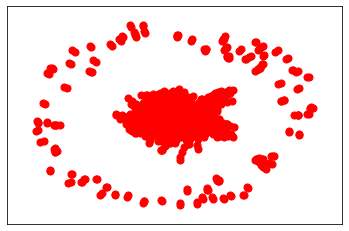

In [55]:
import networkx as nx

g=nx.Graph()
g.add_edges_from(edgeList)
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')

In [6]:
# undirected edges can be used for evaluation
undirected_train_edge_index, 
, _, _ = edge_train_test_split(
    edge_index=graph.edge_index,
    test_size=0.15
)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# use negative_sampling with replace=False to create negative edges for test
undirected_test_neg_edge_index = negative_sampling(
    num_samples=undirected_test_edge_index.shape[1],
    num_nodes=graph.num_nodes,
    edge_index=graph.edge_index,
    replace=False
)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# for training, you should convert undirected edges to directed edges for correct GCN propagation
train_graph = tfg.Graph(x=graph.x, edge_index=undirected_train_edge_index).to_directed()

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
embedding_size = 16
drop_rate = 0.2

gcn0 = tfg.layers.GCN(32, activation=tf.nn.relu)
gcn1 = tfg.layers.GCN(embedding_size)
dropout = tf.keras.layers.Dropout(drop_rate)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
@tf_utils.function
def encode(graph, training=False):
    h = gcn0([graph.x, graph.edge_index, graph.edge_weight], cache=graph.cache)
    h = dropout(h, training=training)
    h = gcn1([h, graph.edge_index, graph.edge_weight], cache=graph.cache)
    return h

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
gcn0.build_cache_for_graph(graph)
gcn0.build_cache_for_graph(train_graph)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
@tf_utils.function
def predict_edge(embedded, edge_index):
    row, col = edge_index[0], edge_index[1]
    embedded_row = tf.gather(embedded, row)
    embedded_col = tf.gather(embedded, col)

    # dot product
    logits = tf.reduce_sum(embedded_row * embedded_col, axis=-1)
    return logits


@tf_utils.function
def compute_loss(pos_edge_logits, neg_edge_logits):
    pos_losses = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=pos_edge_logits,
        labels=tf.ones_like(pos_edge_logits)
    )

    neg_losses = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=neg_edge_logits,
        labels=tf.zeros_like(neg_edge_logits)
    )

    return tf.reduce_mean(pos_losses) + tf.reduce_mean(neg_losses)


def evaluate():
    embedded = encode(train_graph)

    pos_edge_logits = predict_edge(embedded, undirected_test_edge_index)
    neg_edge_logits = predict_edge(embedded, undirected_test_neg_edge_index)

    pos_edge_scores = tf.nn.sigmoid(pos_edge_logits)
    neg_edge_scores = tf.nn.sigmoid(neg_edge_logits)

    y_true = tf.concat([tf.ones_like(pos_edge_scores), tf.zeros_like(neg_edge_scores)], axis=0)
    y_pred = tf.concat([pos_edge_scores, neg_edge_scores], axis=0)

    auc_m = tf.keras.metrics.AUC()
    auc_m.update_state(y_true, y_pred)

    return auc_m.result().numpy()

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

for step in tqdm(range(1000)):
    with tf.GradientTape() as tape:
        embedded = encode(train_graph, training=True)

        # negative sampling for training
        train_neg_edge_index = negative_sampling(
            train_graph.num_edges,
            graph.num_nodes,
            edge_index=None#train_graph.edge_index
        )

        pos_edge_logits = predict_edge(embedded, train_graph.edge_index)
        neg_edge_logits = predict_edge(embedded, train_neg_edge_index)

        loss = compute_loss(pos_edge_logits, neg_edge_logits)

    vars = tape.watched_variables()
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    if step % 20 == 0:
        auc_score = evaluate()
        print("step = {}\tloss = {}\tauc_score = {}".format(step, loss, auc_score))

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 2/1000 [00:01<08:39,  1.92it/s]

step = 0	loss = 1.3862155675888062	auc_score = 0.5953928232192993


  3%|▎         | 26/1000 [00:02<00:45, 21.61it/s]

step = 20	loss = 1.2768280506134033	auc_score = 0.6499073505401611


  4%|▍         | 44/1000 [00:03<00:43, 22.10it/s]

step = 40	loss = 1.089961051940918	auc_score = 0.7553661465644836


  6%|▋         | 65/1000 [00:04<00:40, 23.01it/s]

step = 60	loss = 1.0148732662200928	auc_score = 0.799184262752533


  9%|▊         | 86/1000 [00:05<00:39, 23.22it/s]

step = 80	loss = 0.9887993335723877	auc_score = 0.8202072978019714


 10%|█         | 104/1000 [00:05<00:36, 24.56it/s]

step = 100	loss = 0.9637671113014221	auc_score = 0.8530195951461792


 12%|█▎        | 125/1000 [00:06<00:34, 25.50it/s]

step = 120	loss = 0.9387919902801514	auc_score = 0.8727856278419495


 15%|█▍        | 146/1000 [00:07<00:34, 24.42it/s]

step = 140	loss = 0.9097710847854614	auc_score = 0.8821412920951843


 16%|█▋        | 164/1000 [00:08<00:37, 22.32it/s]

step = 160	loss = 0.8988205194473267	auc_score = 0.8900526165962219


 18%|█▊        | 185/1000 [00:09<00:34, 23.95it/s]

step = 180	loss = 0.8937411308288574	auc_score = 0.8953901529312134


 21%|██        | 206/1000 [00:10<00:31, 25.13it/s]

step = 200	loss = 0.8813381195068359	auc_score = 0.9015717506408691


 22%|██▏       | 224/1000 [00:10<00:32, 23.76it/s]

step = 220	loss = 0.8755007982254028	auc_score = 0.9061424136161804


 24%|██▍       | 245/1000 [00:11<00:36, 20.51it/s]

step = 240	loss = 0.8658033609390259	auc_score = 0.9038945436477661


 26%|██▋       | 263/1000 [00:12<00:38, 19.32it/s]

step = 260	loss = 0.8558204770088196	auc_score = 0.9048048257827759


 28%|██▊       | 285/1000 [00:14<00:35, 20.03it/s]

step = 280	loss = 0.8585630655288696	auc_score = 0.9043002724647522


 30%|███       | 303/1000 [00:15<00:32, 21.71it/s]

step = 300	loss = 0.866489052772522	auc_score = 0.9051013588905334


 32%|███▏      | 324/1000 [00:16<00:34, 19.71it/s]

step = 320	loss = 0.8554021120071411	auc_score = 0.9069554209709167


 34%|███▍      | 344/1000 [00:17<00:31, 20.62it/s]

step = 340	loss = 0.8513948917388916	auc_score = 0.9074568152427673


 36%|███▋      | 365/1000 [00:17<00:24, 25.59it/s]

step = 360	loss = 0.8522881865501404	auc_score = 0.9107927083969116


 38%|███▊      | 384/1000 [00:18<00:27, 22.29it/s]

step = 380	loss = 0.845388650894165	auc_score = 0.9091443419456482


 41%|████      | 406/1000 [00:19<00:24, 24.63it/s]

step = 400	loss = 0.84514319896698	auc_score = 0.9080849289894104


 42%|████▏     | 424/1000 [00:20<00:21, 27.22it/s]

step = 420	loss = 0.8432216048240662	auc_score = 0.9048143625259399


 44%|████▍     | 444/1000 [00:21<00:19, 28.65it/s]

step = 440	loss = 0.837573766708374	auc_score = 0.9037199020385742


 46%|████▋     | 464/1000 [00:21<00:18, 28.59it/s]

step = 460	loss = 0.8464550971984863	auc_score = 0.9051005244255066


 48%|████▊     | 484/1000 [00:22<00:21, 24.04it/s]

step = 480	loss = 0.8467851877212524	auc_score = 0.9032185673713684


 50%|█████     | 504/1000 [00:23<00:18, 27.43it/s]

step = 500	loss = 0.8329836130142212	auc_score = 0.9047370553016663


 52%|█████▎    | 525/1000 [00:24<00:21, 21.85it/s]

step = 520	loss = 0.8360731601715088	auc_score = 0.9035645723342896


 55%|█████▍    | 545/1000 [00:25<00:17, 25.42it/s]

step = 540	loss = 0.834083616733551	auc_score = 0.9037885069847107


 56%|█████▋    | 565/1000 [00:25<00:15, 27.93it/s]

step = 560	loss = 0.83086097240448	auc_score = 0.9037836790084839


 58%|█████▊    | 585/1000 [00:26<00:14, 28.06it/s]

step = 580	loss = 0.8361135125160217	auc_score = 0.9015120267868042


 60%|██████    | 604/1000 [00:27<00:16, 24.70it/s]

step = 600	loss = 0.8334054350852966	auc_score = 0.9027929306030273


 63%|██████▎   | 626/1000 [00:28<00:13, 27.76it/s]

step = 620	loss = 0.826710045337677	auc_score = 0.903343677520752


 64%|██████▍   | 645/1000 [00:28<00:13, 25.54it/s]

step = 640	loss = 0.8354987502098083	auc_score = 0.9012975692749023


 66%|██████▋   | 663/1000 [00:30<00:19, 17.36it/s]

step = 660	loss = 0.8251930475234985	auc_score = 0.9009755253791809


 68%|██████▊   | 683/1000 [00:30<00:13, 22.88it/s]

step = 680	loss = 0.8389800190925598	auc_score = 0.900580108165741


 70%|███████   | 705/1000 [00:31<00:13, 22.20it/s]

step = 700	loss = 0.8186275362968445	auc_score = 0.9020691514015198


 72%|███████▏  | 723/1000 [00:32<00:11, 24.15it/s]

step = 720	loss = 0.8348336815834045	auc_score = 0.8980715870857239


 74%|███████▍  | 742/1000 [00:33<00:11, 22.42it/s]

step = 740	loss = 0.8196341395378113	auc_score = 0.8979743719100952


 76%|███████▋  | 763/1000 [00:34<00:09, 24.62it/s]

step = 760	loss = 0.8178321123123169	auc_score = 0.898210346698761


 78%|███████▊  | 785/1000 [00:35<00:08, 24.96it/s]

step = 780	loss = 0.8331437110900879	auc_score = 0.8957393169403076


 80%|████████  | 803/1000 [00:36<00:08, 23.35it/s]

step = 800	loss = 0.8190881013870239	auc_score = 0.89676833152771


 82%|████████▏ | 822/1000 [00:37<00:09, 18.23it/s]

step = 820	loss = 0.8209145069122314	auc_score = 0.8973454833030701


 84%|████████▍ | 844/1000 [00:37<00:06, 23.90it/s]

step = 840	loss = 0.8195304870605469	auc_score = 0.8989316821098328


 86%|████████▋ | 865/1000 [00:38<00:06, 21.50it/s]

step = 860	loss = 0.8164239525794983	auc_score = 0.8979584574699402


 89%|████████▊ | 886/1000 [00:39<00:04, 23.37it/s]

step = 880	loss = 0.8126521110534668	auc_score = 0.898644745349884


 90%|█████████ | 904/1000 [00:40<00:04, 21.17it/s]

step = 900	loss = 0.8135442733764648	auc_score = 0.8975073099136353


 92%|█████████▏| 924/1000 [00:41<00:02, 26.79it/s]

step = 920	loss = 0.8275092244148254	auc_score = 0.8970911502838135


 94%|█████████▍| 945/1000 [00:42<00:02, 23.31it/s]

step = 940	loss = 0.8161440491676331	auc_score = 0.8982732892036438


 96%|█████████▋| 964/1000 [00:43<00:01, 24.50it/s]

step = 960	loss = 0.8221340179443359	auc_score = 0.8974331021308899


 99%|█████████▊| 987/1000 [00:44<00:00, 26.94it/s]

step = 980	loss = 0.8188257813453674	auc_score = 0.8963841199874878


100%|██████████| 1000/1000 [00:44<00:00, 22.31it/s]
